# Diferenciación Automática

En este colab vamos a explorar una implementación de un grafo de cómputo y algunas operaciones soportadas (podríamos agregarle todas las que querramos), permitiendo por diferenciación automática el cálculo de las derivadas de una función arbitrariamente compleja respecto de sus entradas.

## Implementación

La implementación está basada en 3 ideas principales:

1. Existe un grafo de cómputo *explícito*, utilizando la librería *networkx*, que se construye de manera que sea un grafo dirigido acíclico (["DAG"](https://en.wikipedia.org/wiki/Directed_acyclic_graph)).
  * Cada operación es un nodo
  * Dos operaciones $u, v$ tienen una arista direccional $u \to v$ que las conecta si y sólo si $u$ es una variable de entrada en el cálculo de $v$.
2. Existe una clase base que define el comportamiento requerido para que todas las operaciones puedan "encadenarse" correctamente en el grafo. 
  * Las operaciones soportadas entonces sólo requieren definir las funciones de evaluación dada entradas y derivadas dada últimas entradas guardadas. 
  * Las variables de entrada ("Placeholders") son una operación más, solo que para ellas no está definida la derivada.
3. Como el grafo es un DAG tiene definido (por lo menos) un [ordenamiento topológico](https://en.wikipedia.org/wiki/Topological_sorting) que da una secuencia de nodos que *respeta el orden de cálculo*.
  * Para evaluar se utiliza un orden topológico directo (y el último nodo evaluado es la salida de la función)
  * Para calcular las derivadas se utiliza un orden topológico *reverso* (al revés)

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### Grafo de Cómputo

* Tiene dos métodos para agregar elementos al grafo:
  * `register_input` para agregar una variable de entrada
  * `register_op` para agregar una operación
* El método `forward` le asigna valores a las entradas y pone a andar el grafo para producir la salida.
* El método `backwards` utiliza los valores guardados del último llamado a `forward` para calcular las derivadas de todos los elementos respecto de sus entradas (incluyendo las variables de entrada)
* El método `plot` grafica el grafo de cómputo, utilizando los nombres de las variables o, si `use_op_names==True` los nombres de las operaciones en su lugar.


In [2]:
# computing graph class
class ComputeGraph:
  def __init__(self):
    self.g = nx.DiGraph()
    self.inputs = set()

  def _is_name_unused(self, name):
    if name in self.g:
      raise KeyError(f"Key {name} already exists")

  def register_input(self, name):
    self._is_name_unused(name)

    self.inputs.add(name)

    # aesthetic, doesn't do anything
    self.g.add_node(name, op=Placeholder(name))
  
  def register_op(self, name, op_class, input_names):
    # if some input name does not belong in the graph
    if not set(input_names) <= set(self.g):
      raise KeyError(f"Missing keys in the graph: {set(input_names)-set(self.g)}")
    
    # if name already exists, raise error
    self._is_name_unused(name)

    # add the op node
    self.g.add_node(name, op=op_class(input_names))

    # add edges coming from all inputs
    for input_name in input_names:
      self.g.add_edge(input_name, name)

  def __call__(self, input_values):
    return self.forward(input_values)

  def forward(self, input_values):
    if set(input_values) != set(self.inputs):
      raise KeyError(f"Missing input values: {set(self.inputs)-set(input_values)}")

    # travel the graph in topological order
    var_values = dict(input_values)
    for node_name in nx.topological_sort(self.g):
      ret_value = self.g.nodes[node_name]['op'].forward(var_values)
      var_values[node_name] = ret_value

    # last ret_value is the last function's result, so return that
    return ret_value

  def backwards(self):
    input_dfs = dict()
    # travel the graph in reversed topological order
    for node_name in reversed(list(nx.topological_sort(self.g))):
      # sum of all derivatives of following ops w.r.t. this node
      # may be an empty list => its sum is 0
      successors = self.g.adj[node_name]
      if len(successors) == 0:
        dF = 1 # so that chain rule is not destroyed
      else:
        dF = sum([self.g.nodes[successor]['op'].df(node_name) for successor in successors])

      # if it's an input, add it to return dict
      # else just keep computing derivatives
      if node_name in self.inputs:
        input_dfs[node_name] = dF
      else: 
        self.g.nodes[node_name]['op'].backwards(dF)

    return input_dfs
  
  def plot(self, use_op_names=False):
    node_labels = {node_name:type(self.g.nodes[node_name]['op']).__name__ 
                   for node_name in self.g.nodes} if use_op_names else None
    nx.draw_networkx(self.g, labels=node_labels)

### Operaciones

Tenemos tres tipos de operaciones:
* `BaseOperation` define la clase base con los métodos a overridear. Su existencia podría ser cuestionada, ya que no aporta más que un molde común a las dos próximas.
* `Placeholder` define la clase para las variables independientes, utilizando una especie de función *identidad* para enmascarar que en realidad representa una variable y no una operación.
* `Operation` define la clase base para todas las operaciones, dando wrappers generales para `forward`, `backwards` y `df` de manera que todas las clases que hereden sólo necesiten definir "las cuentas" vía `_forward` y `_backwards`

In [3]:
# base class
class BaseOperation:
  def forward(self, inputs):
   self.__wrong_method(self, 'forward')

  def backwards(self, dF):
    self.__wrong_method(self, 'backwards')

  def df(self, input_name):
    self.__wrong_method(self, 'df')

  def __wrong_method(self, mtd): 
    raise RuntimeError(f"You shouldn't be calling {mtd} on a {type(self).__name__}")

class Placeholder(BaseOperation):
  def __init__(self, name):
    self.name = name

  def forward(self, inputs):
    # just return the value
    return inputs[self.name]

class Operation(BaseOperation):
  required_inputs = set() # this should be overriden

  def __init__(self, name_to_input):
    """
    Params:
    name_to_input: Dict with mappings of op_names to expected_names, e.g. "Name1":"base".
                   This parameter's keys should be all op_names that act as input, and 
                   its values should be all the names the formula comprises.
    """
    assert set(name_to_input.values())==self.required_inputs, "Required inputs are missing"
    self.name_to_input = name_to_input
    self.last_inputs = {}
    self.last_output = None

    # this one should be completed with <required_input> -> float when backwards() is called
    self.dfs = dict()
  
  def _forward(self, inputs):
    raise NotImplementedError("This should have been overriden")

  def forward(self, inputs):
    # translate inputs, restricted to the ones we care about
    inputs = {self.name_to_input[k]:v for k,v in inputs.items() if k in self.name_to_input}
    # calculate output
    self.last_inputs = inputs
    self.last_output = self._forward(inputs)
    return self.last_output

  def _backwards(self):
    # calculate derivatives of this op w.r.t. its inputs
    raise NotImplementedError("This should have been overriden")

  def backwards(self, dF):
    # chain rule
    self.dfs = {k: dF * v for k,v in self._backwards().items()}

  def df(self, input_name):
    own_input = self.name_to_input[input_name]
    return self.dfs[own_input]

### Operaciones definidas

Como todo lo demás ya está hecho antes (en la clase base `Operation`), para cada nueva operación solo debemos definir:

* Un *set* de `required_inputs` que dictan los argumentos que espera la función
* `_forward` que recibe un diccionario cuyas claves son los inputs antes determinados y devuelve el valor de la función evaluada en esos valores de entrada
* `_backwards` que en base a las últimas entradas registradas calcula la derivada de su salida respecto de cada entrada, y devuelve un diccionario de la forma *nombre\_entrada -> valor\_derivada*

In [4]:
class Square(Operation):
  BASE_NAME = 'base'
  required_inputs = {BASE_NAME}

  def __init__(self, name_to_input):
    super().__init__(name_to_input)

  def _forward(self, inputs):
    return inputs[self.BASE_NAME]**2
  
  def _backwards(self):
    base_df = self.last_inputs[self.BASE_NAME] * 2
    return {self.BASE_NAME: base_df}

In [5]:
class Sum(Operation):
  SUM1_NAME = 'summand1'
  SUM2_NAME = 'summand2'
  required_inputs= {SUM1_NAME, SUM2_NAME}

  def __init__(self, name_to_input):
    super().__init__(name_to_input)

  def _forward(self, inputs):
    return inputs[self.SUM1_NAME] + inputs[self.SUM2_NAME]
  
  def _backwards(self):
    return {self.SUM1_NAME: 1, self.SUM2_NAME: 1}

In [6]:
class Product(Operation):
  PROD1_NAME = 'factor1'
  PROD2_NAME = 'factor2'
  required_inputs= {PROD1_NAME, PROD2_NAME}

  def __init__(self, name_to_input):
    super().__init__(name_to_input)

  def _forward(self, inputs):
    return inputs[self.PROD1_NAME] * inputs[self.PROD2_NAME]
  
  def _backwards(self):
    return {self.PROD1_NAME: self.last_inputs[self.PROD2_NAME], 
            self.PROD2_NAME: self.last_inputs[self.PROD1_NAME]}

## Código de prueba

En este ejemplo simple se plantea $b = x^2 \cdot y$ y luego se evalúa y calcula derivadas para $x=5, y=2$.

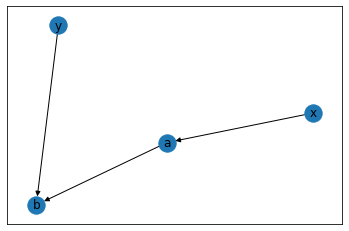

In [7]:
cg = ComputeGraph()
cg.register_input("x")
cg.register_input("y")
cg.register_op("a",Square,{"x":"base"})
cg.register_op("b",Product,{"a":"factor1", "y":"factor2"})
cg.plot()

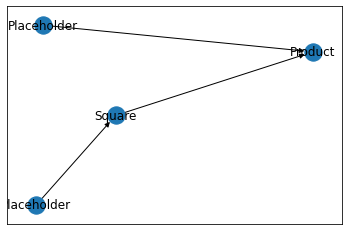

In [8]:
cg.plot(use_op_names=True)

In [9]:
cg({'x':5,'y':2})

50

In [10]:
cg.backwards()

{'x': 20, 'y': 25}

En un segundo ejemplo se plantea
$$
f(x,y,z) = (x^2+y^2)^2 + (z+xy)^2
$$

y se quieren conocer tanto el valor de $f$ como de $f'$ para $x=3,y=2,z=0.5$

In [11]:
cg2 = ComputeGraph()
cg2.register_input("x")
cg2.register_input("y")
cg2.register_input("z")
cg2.register_op("x2",Square,{"x":"base"})
cg2.register_op("y2",Square,{"y":"base"})
cg2.register_op("x2+y2",Sum,{"x2":"summand1", "y2":"summand2"})
cg2.register_op("(x2+y2)2", Square, {"x2+y2":"base"})
cg2.register_op("xy",Product, {"x":"factor1","y":"factor2"})
cg2.register_op("z+xy",Sum, {"z":"summand1", "xy":"summand2"})
cg2.register_op("z+xy ^2", Square, {"z+xy":"base"})
cg2.register_op("f", Sum, {"(x2+y2)2": "summand1", "z+xy ^2": "summand2"})

cg2({'x':3, 'y':2, 'z':0.5})

211.25

In [12]:
cg2.backwards()

{'x': 182.0, 'y': 143.0, 'z': 13.0}

Estos valores se corresponden con los cálculos en wolfram alpha de:

* [derivadas parciales de $f$ respecto de x,y,z](https://www.wolframalpha.com/input?i=differentiate+%28x%5E2%2By%5E2%29%5E2%2B%28z%2Bxy%29%5E2)
* [$\frac{\partial f}{\partial x}(3,2,0.5)$](https://www.wolframalpha.com/input?i=4+x%5E3+%2B+6+x+y%5E2+%2B+2+y+z+at+x%3D3%2Cy%3D2%2Cz%3D0.5)
* [$\frac{\partial f}{\partial y}(3,2,0.5)$](https://www.wolframalpha.com/input?i=6+x%5E2+y+%2B+4+y%5E3+%2B+2+x+z++at+x%3D3%2Cy%3D2%2Cz%3D0.5)
* [$\frac{\partial f}{\partial z}(3,2,0.5)$](https://www.wolframalpha.com/input?i=2+%28x+y+%2B+z%29+at+x%3D3%2Cy%3D2%2Cz%3D0.5)

De donde podemos comprobar cómo, si bien la computadora no sabe realizar cálculo simbólico, como *cada parte* sabe contribuir lo suyo, por regla de la cadena podemos reconstruir las derivadas de la salida respecto de cada entrada.

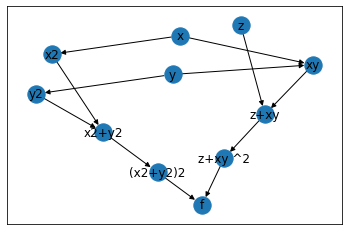

In [19]:
cg2.plot()